This notebook explores plotting a RHI file, calculating Signal to Noise Ratio from radial velocity data and appending a field object and saving the radar object to CF-Radial. We will do this by loading a radar file from CF-Radial from ARM's X-Band system in the North Slope of Alaska Barrow site.

Go fetch the data from <a href = 'https://engineering.arm.gov/~jhelmus/sample_xsapr_a1_files/2013_12_03_NSA/nsaxsaprrhiC1.a1/nsaxsaprrhiC1.a1.20131203.141936.nc'> HERE </a> and place it in the same directory as this notebook.  If you save the file elsewhere adjust the *data_dir* variable to point to the correct directory.

In [8]:
# load relevant modules, set plotting to inline
import pyart
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [9]:
data_dir = ''
filename = 'nsaxsaprrhiC1.a1.20131203.141936.nc'
#filename = 'pvcwsacrhsrhiM1.b1.20121105.201200_modified.nc'
fqfn = data_dir + filename

In [10]:
print fqfn

nsaxsaprrhiC1.a1.20131203.141936.nc


In [11]:
radar = pyart.io.read(fqfn)

In [12]:
# Lets see what moments we have
radar.fields.keys()

[u'reflectivity_horizontal',
 u'cross_correlation_ratio',
 u'normalized_coherent_power',
 u'total_power',
 u'mean_doppler_velocity',
 u'doppler_spectrum_width',
 u'differential_reflectivity',
 u'specific_differential_phase',
 u'differential_phase']

Lets create a nice single RHI plot from the X-SAPR Horizon to Horizon scan.. Py-ART has a series of display routines in pyart.graph . First thing we do is create a display object.

In [13]:
display = pyart.graph.RadarDisplay(radar)

Now we create a Matplotlib figure object and invoke the plot_rhi method

In [14]:
plt.figure?

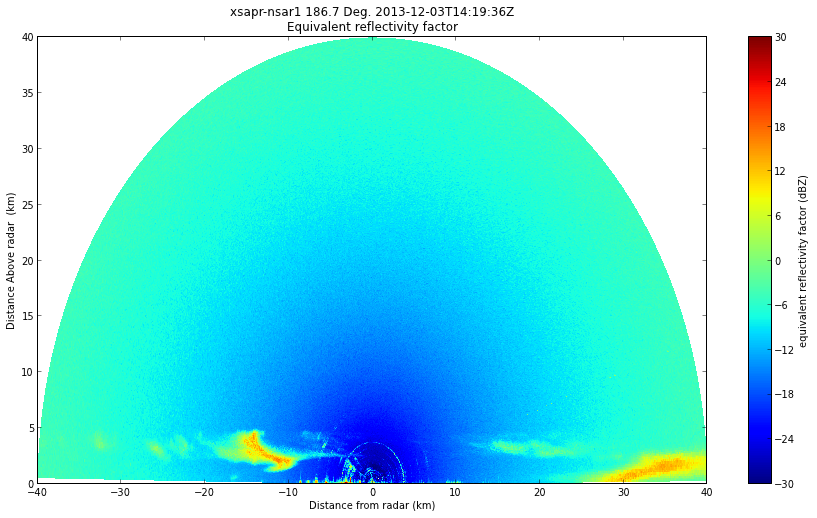

In [17]:
my_figure = plt.figure(figsize=[15, 8])
display.plot_rhi('reflectivity_horizontal', 1, vmin=-30, vmax=30) #1 is the sweep number

Hmmm.. This is a bit big.. Tropopause is not at 40km! Lets trim off some fat!

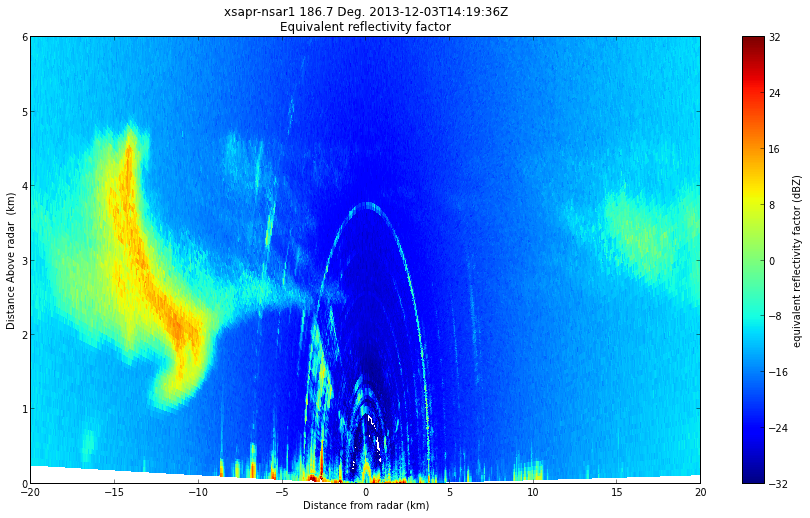

In [20]:
my_figure = plt.figure(figsize=[15, 8])
display.plot_rhi('reflectivity_horizontal', 1, vmin=-32, vmax=32)
display.set_limits(ylim=[0, 6], xlim=[-20,20])

That's right! Setting limits can get you right down to the gate level! Take a look at this and feel free to change things!

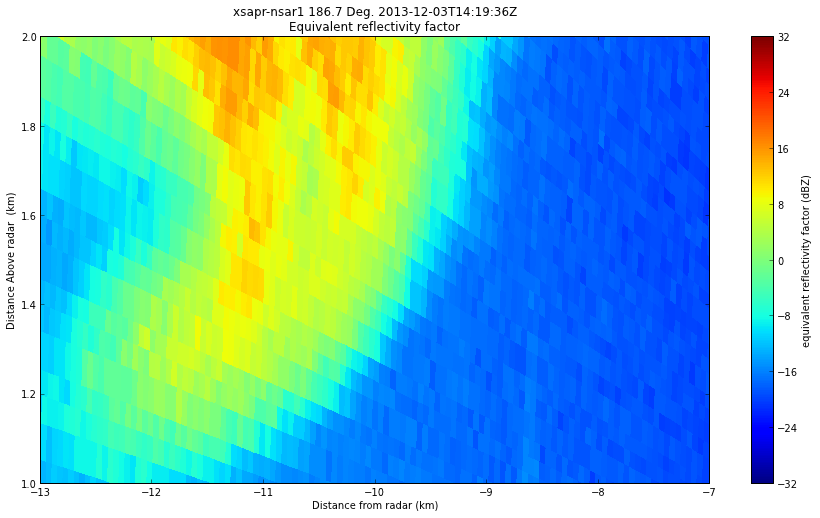

In [21]:
my_figure = plt.figure(figsize=[15, 8])
display.plot_rhi('reflectivity_horizontal', 1, vmin=-32, vmax=32)  # Change to another moment!
display.set_limits(ylim=[1, 2])  # Change me! use the above figure for reference!
display.set_limits(xlim=[-13, -7])  # Change me! use the above figure for reference!

All righty then! Lets get clever.. So Python is a programming language right? Right! So we can script and loop to our hearts content.. Lets make some multi-plot displays! The below introduces a very large number of concepts.. The objects below will be described as comments... 

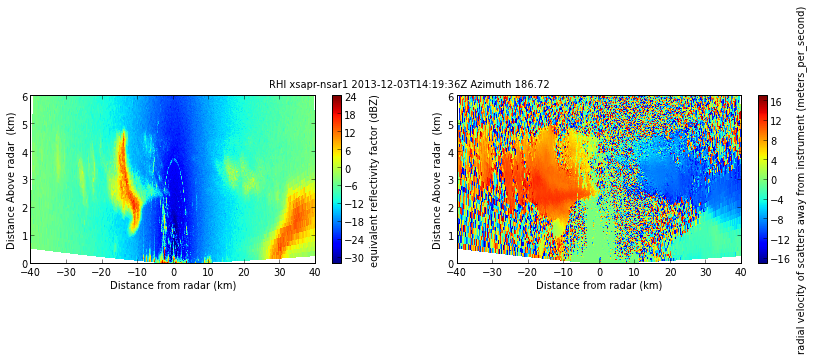

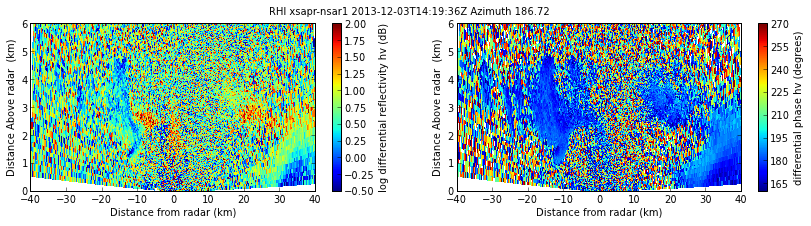

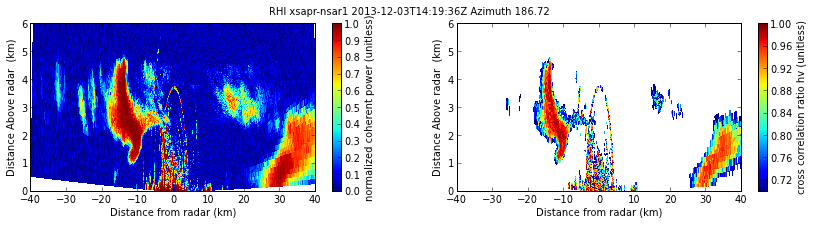

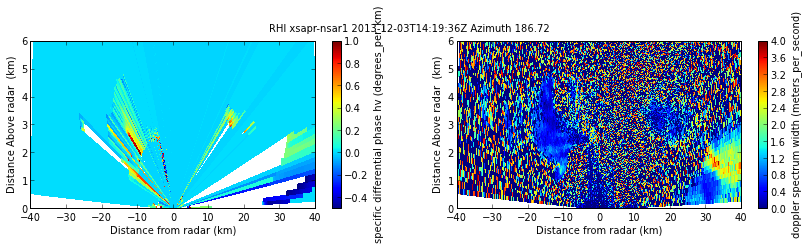

In [23]:
# Lets plot some RHIs

# So first we are going to create a list of pairs of strings..
# these are the two fields to be plotted per line, so in the end we
# have 4 rows and two columns

field_pairs = [['reflectivity_horizontal', 'mean_doppler_velocity'],
               ['differential_reflectivity', 'differential_phase'],
               ['normalized_coherent_power', 'cross_correlation_ratio'],
               ['specific_differential_phase', 'doppler_spectrum_width']]

# so this is a list of tuples. (two-tuples to be exact)
# just like the above!
# these are the value ranges for each of the plots.. please feel free to experiment!

range_pairs= [[(-32, 24), (-17.0, 17.0)],
              [(-0.5, 2.0), (160, 270.0)],
              [(0, 1), (.7, 1.0)],
              [(-0.5, 1), (0., 4.0)]]

# just like above, create a new display

display = pyart.graph.RadarDisplay(radar) #only need to call display once

# Time to loop folks! Note the way Python deals with
# flow control. Indentation.. Deal with it and I promise
# in the end you will love it. 

# looping is done over a list.. the range() function creates 
# a list from 0 to len(field_pairs)-1

for i in range(len(field_pairs)):
    # fields to plot and ranges
    fields_to_plot = field_pairs[i]  # this is now just a pair of strings
    ranges = range_pairs[i]  # this is now a pair of two-tuples
    
    # plot the data
    nplots = len(fields_to_plot)  # This will be 2
    
    #create a matplotlib figure object
    plt.figure(figsize=[7 * nplots, 3])  # you can play with this! 
    
    # plot each field, so here we loop over the two fields per row
    for plot_num in range(nplots): 
        field = fields_to_plot[plot_num]  # grab the field to be plotted for this panel
        vmin, vmax = ranges[plot_num]  # grab the ranges from the two-Tuple
        
        # The below command is a matplotlib command. This creates
        # subplots (Rows, Columns, and current plot)
        # So on the first execution it is a 1 row 2 column at the 1st position
        # and on the second at the 2nd position 
        plt.subplot(1, nplots, plot_num + 1) 
        display.plot_rhi(field, 1, vmin=vmin, vmax=vmax, title_flag=False)  # and you know this! 
        display.set_limits(ylim=[0, 6])  # feel free to play and to add a xlim below!
    
    # set the figure title
    radar_name = display.radar_name  # grab the name of the radar from the display
    time_text = ' ' + display.time_begin.isoformat() + 'Z ' # the display obj helps you! 
    azimuth = radar.fixed_angle['data'][1] 
    title = 'RHI ' + radar_name + time_text + 'Azimuth %.2f' % (azimuth)
    plt.suptitle(title)

Pretty! Yeah.. KDP in the raw X-SAPR file is not well.. But this helps you quickly see that. So now we can explore our data how can we add value? Well we are in a Scientific Python environment so we have a raft of options here! One thing is Texture based significant feature detection... We are going to look at polarimetric based versus using texture based... First lets create some classifications based off purely polarimetric data... 

In [24]:
# So there are a variety of things we can classify off.. And the nice thing is Numpy's where
# function allows great filtering basded on logic! 

# the first two lines create an array of Trues and Falses

is_coherent = radar.fields['normalized_coherent_power']['data'] > 0.5
is_correlated = radar.fields['cross_correlation_ratio']['data'] > 0.8

# Now we are going to do some array based logic math.. 
is_correlated_and_coherent = np.logical_and(is_coherent, is_correlated)
is_correlated_and_not_coherent = np.logical_and(np.logical_not(is_coherent), is_correlated)
is_not_correlated_and_coherent =  np.logical_and(is_coherent, np.logical_not(is_correlated))
is_not_correlated_and_not_coherent = np.logical_and(np.logical_not(is_coherent), 
                                                    np.logical_not(is_correlated))

# initialize a blank array
logical_classes = np.zeros_like(radar.fields['normalized_coherent_power']['data'])

# Now we are going to fill in regions (allowing overwriting) 
# to create a numerical based classificatiob
logical_classes[np.where(is_correlated_and_coherent)] = 1.0
logical_classes[np.where(is_correlated_and_not_coherent)] = 2.0
logical_classes[np.where(is_not_correlated_and_coherent)] = 3.0
logical_classes[np.where(is_not_correlated_and_not_coherent)] = 4.0


Ok.. That was cool.. Now what? We have this array of shape (time, range) how do we get it into our radar data model.. well from the earlier lesson on the Radar Object you will recall a field is simply a dictionary.. So all we need to do is create this dictionary with the data and metadata and invoke the add_field method of the radar object and we are good to go!

In [25]:
# add the field to the radar object
field_dict = {'data' : logical_classes,
              'units' : 'Unitless',
              'long_name' : 'Logical Classifications based on RhoHV and NCP/SQ',
              'standard_name' : "Logical_Class"}

radar.add_field('logical_class', field_dict)   

Yay! Our radar object now has a new field, Logical_class... lets just check:

In [26]:
# Lets see what moments we have
radar.fields.keys()

['logical_class',
 u'reflectivity_horizontal',
 u'cross_correlation_ratio',
 u'normalized_coherent_power',
 u'total_power',
 u'mean_doppler_velocity',
 u'doppler_spectrum_width',
 u'differential_reflectivity',
 u'specific_differential_phase',
 u'differential_phase']

Yep! You know what that means right? We can simply plot the RHI using our display class... 

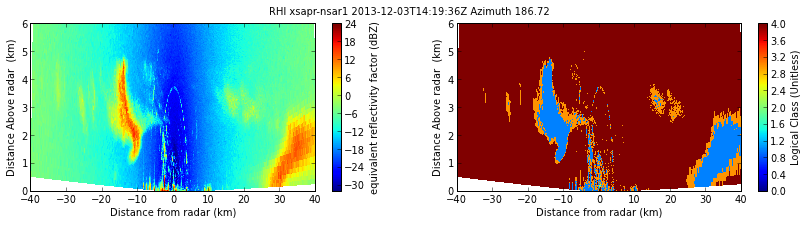

In [27]:
# Lets plot some RHIs
display = pyart.graph.RadarDisplay(radar)

# fields to plot and ranges
fields_to_plot = ['reflectivity_horizontal', 'logical_class']
ranges = [(-32, 24), (0, 4)]

# plot the data
nplots = len(fields_to_plot)
plt.figure(figsize=[7 * nplots, 3])

# plot each field
for plot_num in xrange(nplots):
    field = fields_to_plot[plot_num]
    vmin, vmax = ranges[plot_num]

    plt.subplot(1, nplots, plot_num + 1)
    display.plot_rhi(field, 1, vmin=vmin, vmax=vmax, title_flag=False)
    display.set_limits(ylim=[0, 6])

# set the figure title and show
radar_name = display.radar_name
time_text = ' ' + display.time_begin.isoformat() + 'Z '
azimuth = radar.fixed_angle['data'][1]
title = 'RHI ' + radar_name + time_text + 'Azimuth %.2f' % (azimuth)
plt.suptitle(title)

Ok.. now for the SNR calculations.. Basically we are going to calculate:

$SNR = \frac{<V_r>}{ RMS( V_r)}$

where

$RMS = <(V_r - <V_r>)^2>$

where the angluar brackets denote an 11 point running filter. In this case to make it simpler we are going to use the filter as defined in 
<a href='https://github.com/ARM-DOE/pyart/blob/master/pyart/correct/phase_proc.py#L242' target=newtab> this line of the Py-ART Source code </a>. Essentially it is an 11 point hanning filter convolution.. The tricky bit I am neglecting to include here involves keeping the length of the array constant.. See if you can follow the in-line comments. At the end of the calculation, as before, we simply create a field dictionary and add this back into the radar object.

In [30]:
# time for some texture fields
SNR_VR = np.zeros_like(radar.fields['mean_doppler_velocity']['data'])
for i in range(SNR_VR.shape[0]):
    this_ray_of_data = radar.fields['mean_doppler_velocity']['data'][i,:]
    signal = pyart.correct.phase_proc.smooth_and_trim(this_ray_of_data)
    noise = pyart.correct.phase_proc.smooth_and_trim(np.sqrt((this_ray_of_data - signal) ** 2))
    this_ray_SNR = np.abs(signal) / noise
    SNR_VR[i,:] = this_ray_SNR

field_dict = {'data' : SNR_VR,
              'units' : 'Unitless',
              'long_name' : 'Signal to Noise ratio for mean_doppler_velocity',
              'standard_name' : "SNR_VR"}

radar.add_field('SNR_VR', field_dict)  

ValueError: A field with name: SNR_VR already exists

Lets see what out SNR field looks like:

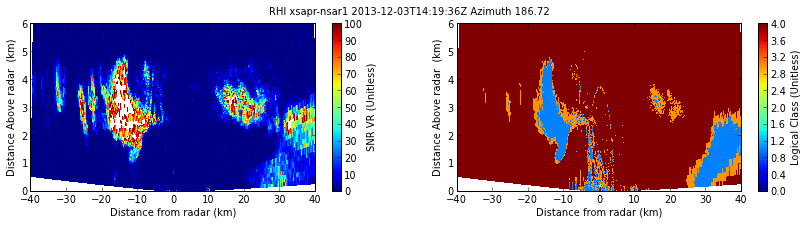

In [31]:
# Lets plot some RHIs
display = pyart.graph.RadarDisplay(radar)

# fields to plot and ranges
fields_to_plot = ['SNR_VR', 'logical_class']
ranges = [(0, 100), (0, 4)]

# plot the data
nplots = len(fields_to_plot)
plt.figure(figsize=[7 * nplots, 3])

# plot each field
for plot_num in xrange(nplots):
    field = fields_to_plot[plot_num]
    vmin, vmax = ranges[plot_num]

    plt.subplot(1, nplots, plot_num + 1)
    display.plot_rhi(field, 1, vmin=vmin, vmax=vmax, title_flag=False)
    display.set_limits(ylim=[0, 6])

# set the figure title and show
radar_name = display.radar_name
time_text = ' ' + display.time_begin.isoformat() + 'Z '
azimuth = radar.fixed_angle['data'][1]
title = 'RHI ' + radar_name + time_text + 'Azimuth %.2f' % (azimuth)
plt.suptitle(title)

Awesome! So we can clearly see where the noise overwhelms the signal.. Are you thinking what I am thinking? We can use both polarimetric data and texture to filter this data.. Lets use a threshold for SNR of 10 and we can use Numpy's Masked Array methods to create fields with non-meteo returns flagged. Follow the in-line comments below

In [32]:
# The below will create an arry of the same shape of SNR_VR but with Trues where SNR < 10.0 
# and Falses where NOT(SNR <10.0)

is_messy = SNR_VR < 10.0 

# Now to Numpy's masked array.. the np.ma module has a variety of methods.. here
# we will use the masked_where method. This is invoked:
# masked_where(condition, data)
# and everywhere where condition = True will be marked as masked in the resultant array
vr_masked_Z = np.ma.masked_where(is_messy, radar.fields['reflectivity_horizontal']['data'])

# Ok.. The below is just the usual creating of a field ready to go back into our radar object. 
# instead of manual entry we simply copy the metadata from the original Z field 
field_dict = {'data' : vr_masked_Z}
for key in ['_FillValue', 'long_name', 'units', 'valid_min', 'valid_max',
            'standard_name', 'coordinates']:
    field_dict.update({key : radar.fields['reflectivity_horizontal'][key]})

# and BOOM! Just add it back into our radar object! 
radar.add_field('vr_filtered_reflectivity_horizontal', field_dict)  

Ok! That was cool! Now lets do <b>exactly the same</b> but using Normalized Coherent Power as our condition.. 

In [33]:
ncp_masked_Z = np.ma.masked_where(np.logical_not(is_coherent), 
                                  radar.fields['reflectivity_horizontal']['data'])
field_dict = {'data' : ncp_masked_Z}
for key in ['_FillValue', 'long_name', 'units', 'valid_min', 'valid_max',
            'standard_name', 'coordinates']:
    field_dict.update({key : radar.fields['reflectivity_horizontal'][key]})

radar.add_field('ncp_filtered_reflectivity_horizontal', field_dict)  

Cool! Now lets see the wealth of value we have added! 

In [34]:
radar.fields.keys()

['logical_class',
 'ncp_filtered_reflectivity_horizontal',
 u'reflectivity_horizontal',
 u'cross_correlation_ratio',
 u'normalized_coherent_power',
 'vr_filtered_reflectivity_horizontal',
 u'total_power',
 u'mean_doppler_velocity',
 u'doppler_spectrum_width',
 u'differential_reflectivity',
 u'specific_differential_phase',
 'SNR_VR',
 u'differential_phase']

Sweet! Lets plot!

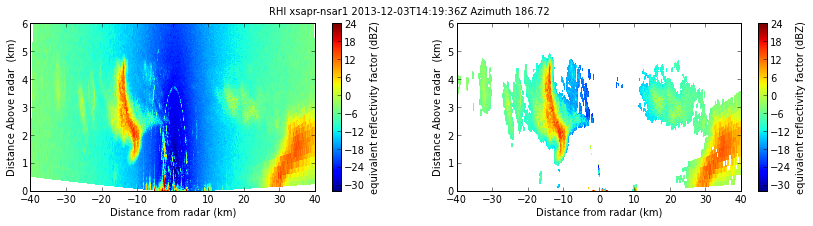

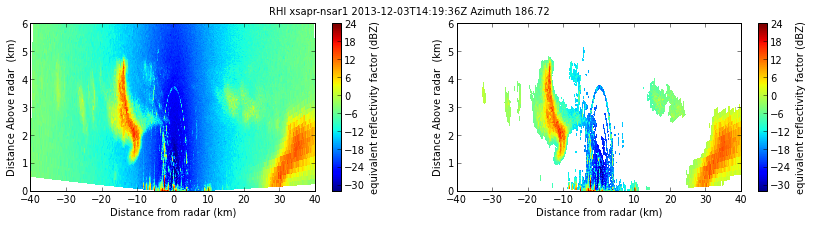

In [35]:
# Lets plot some RHIs
field_pairs = [ ['reflectivity_horizontal', 'vr_filtered_reflectivity_horizontal'],
                ['reflectivity_horizontal', 'ncp_filtered_reflectivity_horizontal']]

range_pairs= [ [(-32, 24), (-32, 24)],
               [(-32, 24), (-32, 24)]]

for i in range(len(field_pairs)):
    display = pyart.graph.RadarDisplay(radar)
    
    # fields to plot and ranges
    fields_to_plot = field_pairs[i]
    ranges = range_pairs[i]
    
    # plot the data
    nplots = len(fields_to_plot)
    plt.figure(figsize=[7 * nplots, 3])
    
    # plot each field
    for plot_num in xrange(nplots):
        field = fields_to_plot[plot_num]
        vmin, vmax = ranges[plot_num]
    
        plt.subplot(1, nplots, plot_num + 1)
        display.plot_rhi(field, 1, vmin=vmin, vmax=vmax, title_flag=False)
        display.set_limits(ylim=[0, 6])
    
    # set the figure title and show
    radar_name = display.radar_name
    time_text = ' ' + display.time_begin.isoformat() + 'Z '
    azimuth = radar.fixed_angle['data'][1]
    title = 'RHI ' + radar_name + time_text + 'Azimuth %.2f' % (azimuth)
    plt.suptitle(title)

Nice.. You can see we need some refinement.. This is left to the reader .. and when you are done submit a pull request back to Py-ART and you have done my job for me! One final step.. and it is the coolest.. Lets save it.. Py-ART looks after saving to a CF-Radial complaint netCDF file for you! All metadata preserved.. Run this (change output directory of course) and you can go and ncdump to your hearts content! 

In [36]:
directory_to_save_to = ''
filename_to_save_to = 'my_cool_file.nc'
pyart.io.write_cfradial(directory_to_save_to + filename_to_save_to, radar)

Thus concludes the Tutorial! Questions? Comments? Science Lead: <a href = 'mailto:scollis@anl.gov'> Scott Collis</a> Development lead: <a href = 'mailto:jhelmus@anl.gov'>Jonathan Helmus</a>.